# Importing packages

In [2]:
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import applications
from keras.optimizers import Adam
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tqdm import tqdm
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras import backend as K
from keras.layers import Activation,Dense

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('train')
types = os.listdir('train')
print(types)

['cancer', 'non-cancer']


# Image preprocessing

In [4]:
oral=[]
for item in dataset_path:
    folder = os.listdir('train'+'/'+item)
    for file2 in folder:
        oral.append((item,str('train'+'/'+item)+'/'+file2))

In [5]:
df = pd.DataFrame(data=oral,columns=['cancer type','image'])
df.head()

,cancer type,image
0,cancer,train/cancer/01960a64-cfe8-444d-bbc5-575c15389...
1,cancer,train/cancer/01960a64-cfe8-444d-bbc5-575c15389...
2,cancer,train/cancer/01960a64-cfe8-444d-bbc5-575c15389...
3,cancer,train/cancer/01960a64-cfe8-444d-bbc5-575c15389...
4,cancer,train/cancer/01960a64-cfe8-444d-bbc5-575c15389...


In [6]:
# Balanced data
oral_count = df['cancer type'].value_counts()
print(oral_count)

non-cancer    500
cancer        500
Name: cancer type, dtype: int64


In [7]:
import cv2
path = 'train/'
im_size = 224
images = []
labels = []

for i in dataset_path:
    datapath = path+ str(i)
    filenames = [i for i in os.listdir(datapath)]
    
    for f in filenames:
        img = cv2.imread(datapath+'/'+ f)
        img = cv2.resize(img,(im_size,im_size))
        images.append(img)
        labels.append(i)

In [17]:
IMAGE_SHAPE = (224,224,3)
CLASS_NUM =2
epochs= 25

In [9]:
images = np.array(images)
images.shape

(1000, 224, 224, 3)

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = df['cancer type'].values
print(y[:5])

# for y
# converting string label to numerical for label encoding is required

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)

['cancer' 'cancer' 'cancer' 'cancer' 'cancer']


In [11]:
# converting categorical features as a one hot numeric array 
y = y.reshape(-1,1)
onhot = OneHotEncoder()
Y = onhot.fit_transform(y).todense()
Y.shape

(1000, 2)

# Train and test splitting

In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images,Y = shuffle(images,Y,random_state = 1)

X_train,X_test,y_train,y_test = train_test_split(images,Y,test_size=0.2,random_state=415)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 224, 224, 3)
(200, 224, 224, 3)
(800, 2)
(200, 2)


# Vgg-16 Architecture

In [13]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [19]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Earlystopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=4, 
    min_delta=0.001, 
    mode='max')

# Training

In [21]:
history = model.fit(X_train,y_train, epochs=epochs,validation_split=0.1, 
    batch_size=32, 
    verbose=2,callbacks=[early_stopping])

Epoch 1/25
23/23 - 785s - loss: 0.7760 - accuracy: 0.8833 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 2/25
23/23 - 779s - loss: 0.0582 - accuracy: 0.9875 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 3/25
23/23 - 778s - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/25
23/23 - 779s - loss: 0.0178 - accuracy: 0.9875 - val_loss: 9.3451e-04 - val_accuracy: 1.0000
Epoch 5/25
23/23 - 781s - loss: 0.0175 - accuracy: 0.9889 - val_loss: 7.4688e-04 - val_accuracy: 1.0000


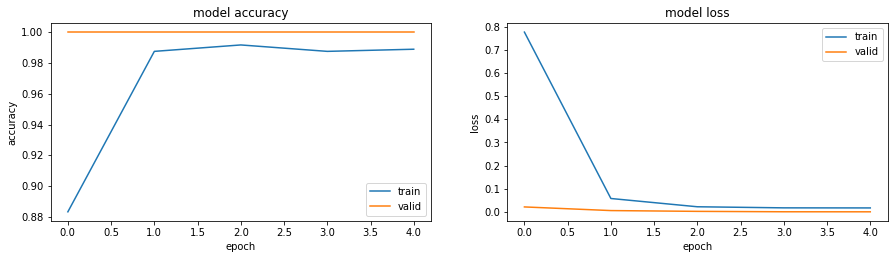

In [23]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [24]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 59s 8s/step - loss: 0.0062 - accuracy: 0.9950


[0.0061781941913068295, 0.9950000047683716]

In [ ]:
pred = model.predict(X_test)
pred

In [26]:
model.save("Model_Vgg16.h5")

# Testing with single image

In [27]:
from keras.models import load_model
from collections import deque
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

In [28]:
model = load_model('Model_Vgg16.h5')

In [30]:
from keras.preprocessing import image
# from tkinter.filedialog import askopenfile
# file = askopenfile(mode='r',filetypes=[('All files','*.jpg')])
# image1 = cv2.imread(str(file.name))
image1 = cv2.imread(r'E:\berlin\Oral cancer\train\cancer\3-s2.0-B9780443100734500148-f10-07-9780443100734 - Copy (3).jpg')
imag = cv2.resize(image1, (224,224))
x = image.img_to_array(imag)
x = np.expand_dims(x,axis=0)
images = np.vstack([x])
#model = load_model('my_model_v1.h5')
classes = model.predict(images,batch_size=32)[0]
print(classes)

[9.9999982e-01 1.8376593e-06]


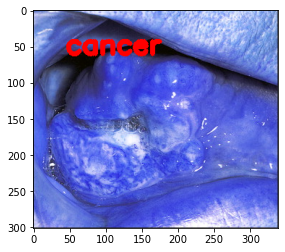

In [31]:
if max(classes)== classes[0]:
    text = 'cancer'
else:
    text = 'non cancer'
cv2.putText(image1,text,(45,60),cv2.FONT_HERSHEY_SIMPLEX,1.25,(255,0,0),5)  
plt.imshow(image1)
plt.show()